# Home Assignment 1

Letters classifier from different computer fonts

### Imports

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from threading import Thread

### Load Data
Load images as vectors

In [6]:
## Sample size
train = 6000
test = 750

## Dimensions can be changed and images will be rescaled in the next section
d = 28*28
size = (28,28)
    
def load_train_data(ntrain=2000):
    A_train = np.array([cv2.imread("data/train/A/A_train_%d.png" % i, 0) for i in range(1, ntrain+1)])
    B_train = np.array([cv2.imread("data/train/B/B_train_%d.png" % i, 0) for i in range(1, ntrain+1)])
    C_train = np.array([cv2.imread("data/train/C/C_train_%d.png" % i, 0) for i in range(1, ntrain+1)])
    Y = np.concatenate((np.ones(ntrain), -1*np.ones(2*ntrain)))
    X = np.concatenate((A_train, B_train, C_train))
    
    return X, Y

def load_test_data(ntest=250):
    A_test = np.array([cv2.imread("data/test/A/A_test_%d.png" % i, 0) for i in range(1, ntest+1)])
    B_test = np.array([cv2.imread("data/test/B/B_test_%d.png" % i, 0) for i in range(1, ntest+1)])
    C_test = np.array([cv2.imread("data/test/C/C_test_%d.png" % i, 0) for i in range(1, ntest+1)])
    Y = np.concatenate((np.ones(ntest), -1*np.ones(2*ntest)))
    X =  np.concatenate((A_test, B_test, C_test))
    return X, Y


## Load train and test data
X_train, Y_train = load_train_data()
X_test, Y_test = load_test_data()

In [7]:
################# DATA PROCESSING

## Reduce dimension and flatten images
X_train = np.array([cv2.resize(x, dsize=size, interpolation=cv2.INTER_CUBIC).flatten() for x in X_train])
X_test = np.array([cv2.resize(x, dsize=size, interpolation=cv2.INTER_CUBIC).flatten() for x in X_test])

## Normalize features
X_train = np.apply_along_axis(lambda c : (c - np.mean(c))/np.std(c), 0, X_train)
X_test = np.apply_along_axis(lambda c : (c - np.mean(c))/np.std(c), 0, np.concatenate((X_train, X_test)))[6000::]

# Exercise 3

## Losses
We implement three utility functions to compute the squared loss and logistic loss along with their gradients (for linear models) as well as the 0-1 loss to measure performances.

#### Squared loss
$\ell_2(\theta) = \frac{1}{n} \sum_{i = 1}^n (\theta^\top X_i - Y_i)^2$ <br/>
$\nabla \ell_2(\theta) = \frac{2}{n} \sum_{i = 1}^n X_i(\theta^\top X_i - Y_i)$

#### Logistic loss
$\ell_3(\theta) = \frac{1}{n} \sum_{i = 1}^n \log (1 + e^{-\theta^\top X_iY_i})$ <br/>
$\nabla \ell_3(\theta) = \frac{1}{n} \sum_{i = 1}^n \frac{-X_iY_i e^{-\theta^\top X_iY_i}}{1 + e^{-\theta^\top X_iY_i}}$


In [8]:
############ Squared loss, logistic loss and 01 loss for linear models

def squared_loss(theta, x, y, test_x=None, test_y=None):
    ## Compute training loss and gradient
    xtheta = np.dot(x, theta)
    loss_train = (1/len(y))*np.sum((xtheta - y)**2)
    grad = (2/len(y))*np.dot(x.T, (xtheta - y))
    
    ## Compute test loss if not None
    loss_test = None
    if(test_x is not None and test_y is not None):
        loss_test = (1/len(test_y))*np.sum((np.dot(test_x, theta) - test_y)**2)
        
    return loss_train, loss_test, grad

def logistic_loss(theta, x, y, test_x=None, test_y=None):
    ## Compute training loss and gradient
    xtheta = np.dot(x, theta)
    expo = np.exp(-xtheta*y)
    loss_train = (1/len(y))*np.sum(np.log(1 + expo))
    grad = (-1/len(y))*np.dot(x.T, y*expo/(1+expo))
    
    ## Compute test loss if not None
    loss_test = None
    if(test_x is not None and test_y is not None):
        loss_test = (1/len(test_y))*np.sum(np.log(1 + np.exp(-np.dot(test_x, theta)*test_y)))
    
    return loss_train, loss_test, grad


def loss01(theta, x, y, test_x=None, test_y=None):
    ## Compute 0-1 loss train
    pred_train = np.sign(np.dot(x, theta))
    loss_train = (1/len(y))*np.sum([0 if pred_train[i] == y[i] else 1 for i in range(len(y))])
    
    ## Compute 0-1 loss test
    loss_test = None
    if(test_x is not None and test_y is not None):
        pred_test = np.sign(np.dot(test_x, theta))
        loss_test = (1/len(test_y))*np.sum([0 if pred_test[i] == test_y[i] else 1 for i in range(len(test_y))])
    
    return loss_train, loss_test


## First order methods
We implement the gradient descent and stochastic gradient descent algorithms with constant (by hand) learning rate.

In [9]:
def gd(X, Y, test_x, test_y, theta0, lr, nb_iter, loss):
    theta = theta0
    loss_train = []
    loss_test = []
    loss_train01 = []
    loss_test01 = []
    for i in range(1, nb_iter+1):
        ## Loss train and test (squared loss or logistic loss)
        loss_train_i, loss_test_i, grad = loss(theta, X, Y, test_x, test_y)
        loss_train.append(loss_train_i)
        loss_test.append(loss_test_i)
        
        ## 01 loss
        loss_01_train_i, loss_01_test_i = loss01(theta, X, Y, test_x, test_y)
        loss_train01.append(loss_01_train_i)
        loss_test01.append(loss_01_test_i)
        
        ## Update
        theta = theta - lr*grad
    return theta, loss_train, loss_test, loss_train01, loss_test01


def sgd(X, Y, test_x, test_y, theta0, lr, nb_iter, loss):
    theta = theta0
    loss_train = []
    loss_test = []
    loss_train01 = []
    loss_test01 = []
    for i in range(1, nb_iter+1):
        index = np.random.randint(low=0, high=len(Y), size=1)
        loss_train_i, loss_test_i, grad = loss(theta, np.array(X[index]), np.array(Y[index]), test_x, test_y)
        loss_train.append(loss_train_i)
        loss_test.append(loss_test_i)
        
        ## 01 loss
        loss_01_train_i, loss_01_test_i = loss01(theta, X, Y, test_x, test_y)
        loss_train01.append(loss_01_train_i)
        loss_test01.append(loss_01_test_i)
        
        theta = theta - lr*grad        
    return theta, loss_train, loss_test, loss_train01, loss_test01


def cummean(x):
    return np.cumsum(x)/np.arange(1, len(x)+1)


### (a) Logistic regression train and test errors with GD and SGD

#### Test gradient descent and stochastic gradient descent

In [10]:
## Parameters
theta0 = 1e-3*np.ones(d)
epoch = 10

## Gradient descent
theta_s, loss_s, loss_ts, loss01_s, loss01_ts = gd(X_train, Y_train, X_test, Y_test, theta0, 0.005, epoch, squared_loss)
theta_l, loss_l, loss_tl, loss01_l, loss01_tl  = gd(X_train, Y_train, X_test, Y_test, theta0, 0.4, epoch, logistic_loss)

## Stochastic gradient descent
stheta_s, sloss_s, sloss_ts, sloss01_s, sloss01_ts = sgd(X_train, Y_train, X_test, Y_test, theta0, 0.000001, train*epoch, squared_loss)
stheta_l, sloss_l, sloss_tl, sloss01_l, sloss01_tl = sgd(X_train, Y_train, X_test, Y_test, theta0, 0.00001, train*epoch, logistic_loss)

### Training and test cumulative losses (squared and logistic) for GD and SGD

/home/chris/venv/vvenv/lib/python3.6/site-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


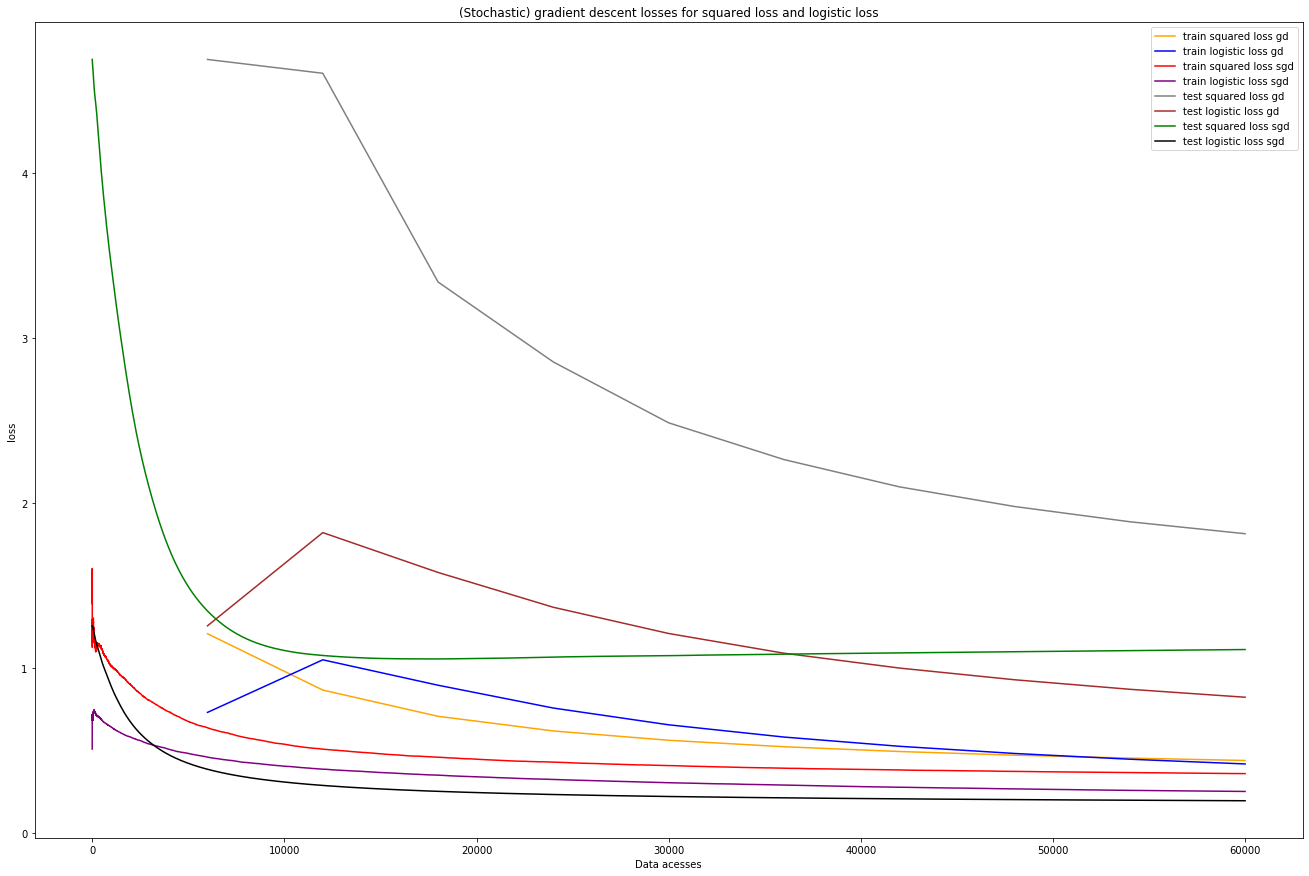

In [11]:
## Training and test error plots for SGD and GD with logistic loss and squared loss

## Look from iteration (must be multiple of train size)
from_iter = 0

plt.figure(figsize=(50, 15))
plt.subplot(1, 2, 2)

### Plot training losses
## GD squared loss and logistic loss
plt.plot(range(train, epoch*train+1 - from_iter, train), cummean(loss_s[int(from_iter/train)::]), color = 'orange', label='train squared loss gd')
plt.plot(range(train, epoch*train+1 - from_iter, train), cummean(loss_l[int(from_iter/train)::]), color = 'blue', label='train logistic loss gd')
## SGD squared loss and logistic loss
plt.plot(range(epoch*train - from_iter), cummean(sloss_s[from_iter::]), color = 'red', label='train squared loss sgd')
plt.plot(range(epoch*train - from_iter), cummean(sloss_l[from_iter::]), color = 'purple', label='train logistic loss sgd')


### Plot test losses
## GD squared loss and logistic loss
plt.plot(range(train, epoch*train+1 - from_iter, train), cummean(loss_ts[int(from_iter/train)::]), color = 'gray', label='test squared loss gd')
plt.plot(range(train, epoch*train+1 - from_iter, train), cummean(loss_tl[int(from_iter/train)::]), color = 'brown', label='test logistic loss gd')
## SGD squared loss and logistic loss
plt.plot(range(epoch*train - from_iter), cummean(sloss_ts[from_iter::]), color = 'green', label='test squared loss sgd')
plt.plot(range(epoch*train - from_iter), cummean(sloss_tl[from_iter::]), color = 'black', label='test logistic loss sgd')

plt.legend()
plt.ylabel('loss')
plt.xlabel('Data acesses')
plt.title('(Stochastic) gradient descent losses for squared loss and logistic loss')
plt.show()



### Training and test errors (0-1 loss)

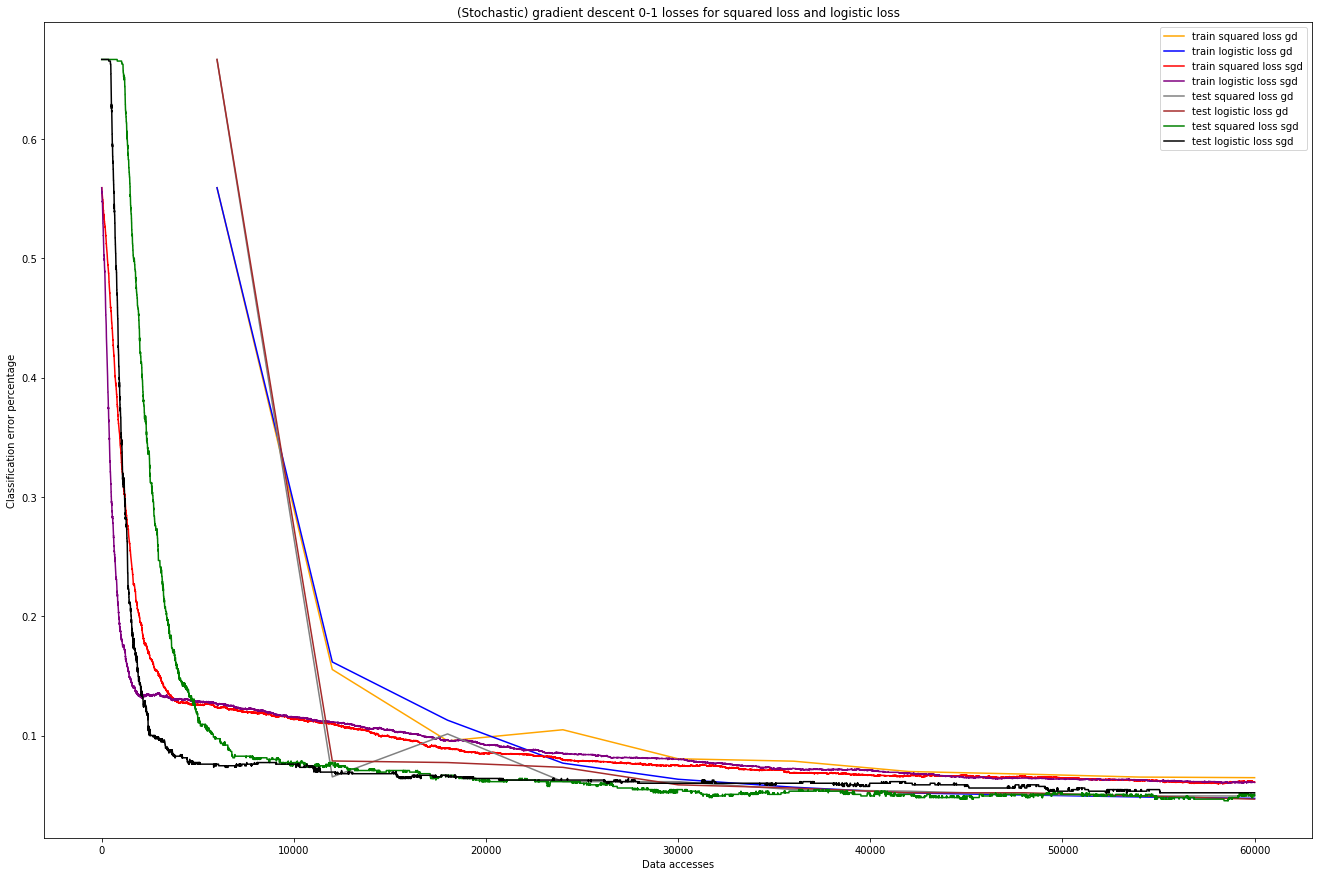

In [12]:
## Training and test error plots for SGD and GD with 01 loss

## Look from iteration (must be multiple of train size)
from_iter = 0

plt.figure(figsize=(50, 15))
plt.subplot(1, 2, 2)

### Plot training losses
## GD 0-1 loss with of the squared loss and logistic loss estimation
plt.plot(range(train, epoch*train+1 - from_iter, train), loss01_s[int(from_iter/train)::], color = 'orange', label='train squared loss gd')
plt.plot(range(train, epoch*train+1 - from_iter, train), loss01_l[int(from_iter/train)::], color = 'blue', label='train logistic loss gd')
## SGD 0-1 loss with of the squared loss and logistic loss estimation
plt.plot(range(epoch*train - from_iter), sloss01_s[from_iter::], color = 'red', label='train squared loss sgd')
plt.plot(range(epoch*train - from_iter), sloss01_l[from_iter::], color = 'purple', label='train logistic loss sgd')


### Plot test losses
## GD 0-1 loss with of the squared loss and logistic loss estimation
plt.plot(range(train, epoch*train+1 - from_iter, train), loss01_ts[int(from_iter/train)::], color = 'gray', label='test squared loss gd')
plt.plot(range(train, epoch*train+1 - from_iter, train), loss01_tl[int(from_iter/train)::], color = 'brown', label='test logistic loss gd')
## SGD 0-1 loss with of the squared loss and logistic loss estimation
plt.plot(range(epoch*train - from_iter), sloss01_ts[from_iter::], color = 'green', label='test squared loss sgd')
plt.plot(range(epoch*train - from_iter), sloss01_tl[from_iter::], color = 'black', label='test logistic loss sgd')

plt.legend()
plt.ylabel('Classification error percentage')
plt.xlabel('Data accesses')
plt.title('(Stochastic) gradient descent 0-1 losses for squared loss and logistic loss')

plt.show()


### (b) Estimator plots for linear regression and logistic regression

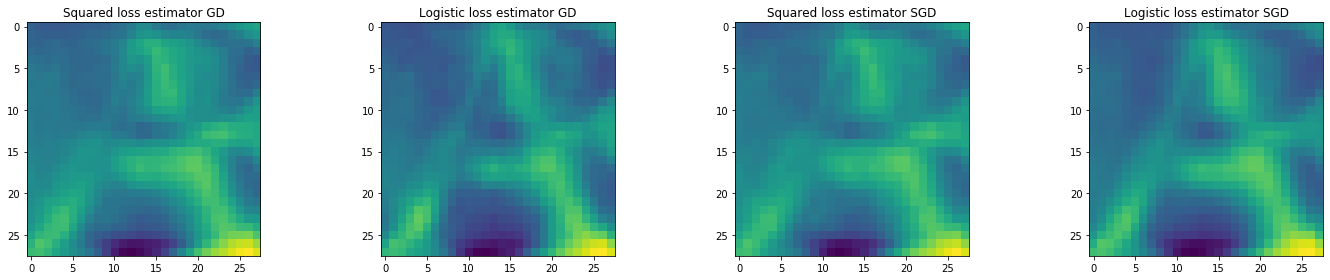

In [13]:
## Estimator plot for squared loss and logistic loss using gradient descent
plt.figure(figsize=(20, 4))

plt.subplot(1, 4, 1)
plt.imshow(theta_s.reshape(size))
plt.title('Squared loss estimator GD')

plt.subplot(1, 4, 2)
plt.imshow(theta_l.reshape(size))
plt.title('Logistic loss estimator GD')

plt.subplot(1, 4, 3)
plt.imshow(stheta_s.reshape(size))
plt.title('Squared loss estimator SGD')

plt.subplot(1, 4, 4)
plt.imshow(stheta_l.reshape(size))
plt.title('Logistic loss estimator SGD')

plt.tight_layout()

### (c) Averaged estimators

In [21]:
def avg_estimators(x, y, theta0, lr, iter_list, loss):
    theta_list = []
    theta = theta0
    theta_avg = theta0

    for i in range(max(iter_list)):
        theta, ltrain, ltest, l01, ltest01 = sgd(x, y, None, None, theta, lr, 1, loss)
        theta_avg = (1/(i+2))*theta + ((i+1)/(i+2))*theta_avg
        if (i+1) in iter_list:
            theta_list.append(theta_avg)
    return theta_list

In [22]:
theta0 = 1e-3*np.ones(d)
iter_list = [10, 100, 1000, 10000]

theta_avgs = avg_estimators(X_train, Y_train, theta0, 0.000001, [10, 100, 1000, 10000], squared_loss)
theta_avgl = avg_estimators(X_train, Y_train, theta0, 0.00001, [10, 100, 1000, 10000], logistic_loss)

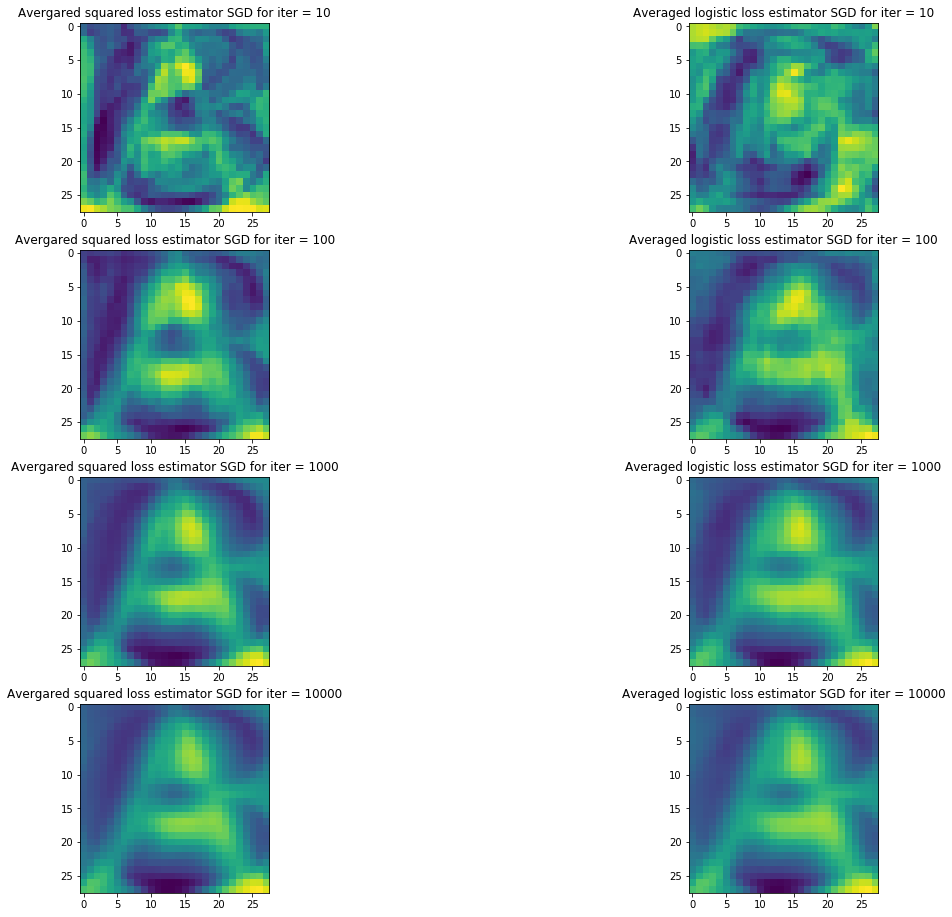

In [24]:
plt.figure(figsize=(20, 4*len(iter_list)))

for i in range(len(theta_avgs)):
        plt.subplot(len(iter_list), 2, 2*i+1)
        plt.imshow(theta_avgs[i].reshape(size))
        plt.title('Avergared squared loss estimator SGD for iter = ' + str(iter_list[i]))

        plt.subplot(len(iter_list), 2, 2*(i+1))
        plt.imshow(theta_avgl[i].reshape(size))
        plt.title('Averaged logistic loss estimator SGD for iter = ' + str(iter_list[i]))
plt.show()

# Exercise 4

In [8]:
## BALANCE THE DATASET (equal number of training A and not A)

## Balance the dataset
#train_range = np.concatenate(([i for i in range(2000)], 
#                               np.random.randint(low=2000, high=4000, size=1000),
#                               np.random.randint(low=4000, high=6000, size=1000)))

## No balance
train_range = [i for i in range(train)]


X_train_balanced = [X_train[i] for i in train_range]
Y_train_balanced = [Y_train[i] for i in train_range]

### (b) Implementation of k-NN and plots of training and test errors (with parallelism)

In [9]:
def knn(x_train, y_train, x, k, dist=lambda x, y: np.sum((x-y)**2)**0.5):
    n = len(y_train)
    if k > n or k == 0:
        raise ValueError('k = 0 or k < n')
        
    p = np.shape(x)[0]
    
    ## Closest neighbors indexes and distances (ordered) for all test data
    neighbors_index = np.array([np.full(k, np.inf, dtype = np.int32) for i in range(p)])
    neighbors_dist = np.array([np.full(k, np.inf) for i in range(p)])
    
    for i in range(n):
        for j in range(p):
            ## Compute distance between training sample and test value
            d = dist(x_train[i], x[j])
            ## Check if it is one of the smallest distances
            if d < neighbors_dist[j][0]:
                ## Update closest distance and index lists and insert this value in the right place
                neighbors_dist[j][0] = d
                neighbors_index[j][0] = i
                s = 1
                while(s < k and d < neighbors_dist[j][s]):
                    neighbors_dist[j][s-1] = neighbors_dist[j][s]
                    neighbors_index[j][s-1] = neighbors_index[j][s]
                    
                    neighbors_dist[j][s] = d
                    neighbors_index[j][s] = i
                    s += 1
                    
    ## Get labels of closest neighbors and count to get the labels of test data
    out = [[y_train[j] for j in neighbors_index[i]] for i in range(p)]
    y_counts = [1 if np.sum(out[i]) > 0 else -1 for i in range(p)]
    
    return y_counts
    

In [10]:
## COMPUTE TRAINING AND TEST ERRORS AS FUNCTION OF k
def test_knn(krange, x_train, y_train, x_test, y_test):
    ## Init loss vectors for train and test data
    kloss_train = [[] for i in krange]
    kloss_test = [[] for i in krange]
    
    ## Prediction function for train and test data
    def pred(x_train, y_train, x_test, y_test, k, index):
        y_pred_train = knn(x_train, y_train, x_train, k)
        y_pred_test = knn(x_train, y_train, x_test, k)
        ## Update the 0-1 loss percentage
        kloss_train[index] = np.sum([0 if y_pred_train[i] == y_train[i] else 1 for i in range(len(y_train))])/len(y_train)
        kloss_test[index] = np.sum([0 if y_pred_test[i] == y_test[i] else 1 for i in range(len(y_test))])/len(y_test)
    
    klist = list(krange)
    ## Create threads each one predicts a value of k
    threads = [Thread(target=pred, args=(x_train, y_train, x_test, y_test, klist[i], i)) for i in range(len(klist))]
    
    for th in threads:
        th.start()
    
    for th in threads:
        th.join()
    
    return kloss_train, kloss_test


krange = range(1, 7)
k_loss_train, k_loss_test = test_knn(krange, X_train_balanced, Y_train_balanced, X_test, Y_test)

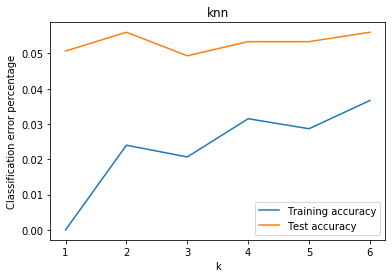

In [11]:
## PLOT TRAINING AND TEST ERRORS AS FUNCTION OF k
plt.plot(krange, k_loss_train, label='Training accuracy')
plt.plot(krange, k_loss_test, label='Test accuracy')
plt.legend()
plt.ylabel('Classification error percentage')
plt.xlabel('k')
plt.title('knn')
plt.show()

### (c) Calibration of k (with parallelism)

In [12]:
def k_fold_knn(x, y, nset, k):
        
        n = len(y)
        chunk = int(np.floor(n/nset))
        
        ## Load data
        random_indexes = np.array(range(n))
        np.random.shuffle(random_indexes)
        
        x = np.array([x[i] for i in random_indexes])
        y = np.array([y[i] for i in random_indexes])
        
        loss = 0
        
        ## TODO: Maybe last chunk too small
        xsets = np.array([x[i:(i+chunk)] for i in range(0, n-1, chunk)])
        ysets = np.array([y[i:(i+chunk)] for i in range(0, n-1, chunk)])
        
        ## Compute loss for each set as test data and the rest as training
        for s in range(nset):
            
            ## Sample data
            xtest = xsets[s]
            ytest = ysets[s]
            
            xtrain = np.array([np.array(xsets[a]).flatten() for a in range(nset) if a != s]).reshape(-1, xsets.shape[-1])
            ytrain = np.array([ysets[a] for a in range(nset) if a != s]).flatten()

            yres = knn(xtrain, ytrain, xtest, k)
            
            loss += np.sum([0 if yres[i] == ytest[i] else 1 for i in range(len(ytest))])/len(ytest)
            
        return (loss/nset)
    

def find_k(x, y, k_values, nset=5):
    
    scores = [0 for i in k_values]
    klist = list(k_values)
    
    ## For all values of k compute the loss using K-fold algorithm with K = 5
    def compute_loss(x, y, nset, k, index):
        loss = k_fold_knn(x, y, nset, k)
        scores[index] = loss
    
    ## Compute each k in different thread
    threads = [Thread(target=compute_loss, args=(x, y, nset, klist[i], i)) for i in range(len(klist))]
    
    for th in threads:
        th.start()
        
    for th in threads:
        th.join()
        
    return k_values[np.argmin(scores)], scores
            
        
        

In [13]:
krange2 = range(1, 7)

## COMPUTE TRAINING AND TEST ERRORS
kopt, scores = find_k(np.concatenate((X_train_balanced, X_test)), 
                      np.concatenate((Y_train_balanced, Y_test)), 
                      krange2)

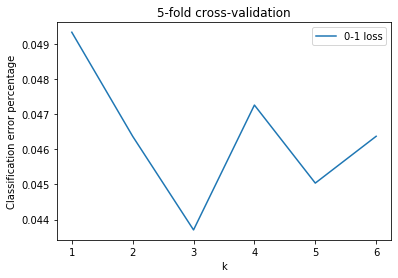

In [14]:
## PLOT TRAINING AND TEST ERRORS AS FUNCTION OF k
plt.plot(krange2, scores, label='0-1 loss')
plt.legend()
plt.ylabel('Classification error percentage')
plt.xlabel('k')
plt.title('5-fold cross-validation')
plt.show()